In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pickle
import sys
sys.path.insert(0,'../code/functions/')
import connectLib as cLib
import plosLib as pLib
import mouseVis as mv 
import tiffIO as tIO
import cv2
from random import randrange as rand
import scipy.ndimage as ndimage
import plotly
plotly.offline.init_notebook_mode()
from IPython.display import IFrame

# 1. Pseudocode

In [3]:
IFrame("AdaptivePseudocode.pdf", width=600, height=600)

# 2. Actual Code

In [4]:
def adaptiveThreshold(inImg, sx, sy, sz, p):
    outImg = np.zeros_like(inImg)
    shape = outImg.shape
    subXLen = shape[0]/sx
    subYLen = shape[1]/sy
    subZLen = shape[2]/sz
    for xInc in range(1, sx + 1):
        for yInc in range(1, sy + 1):
            for zInc in range(1, sz + 1):
                sub = inImg[(xInc-1)*subXLen: xInc*subXLen, (yInc-1)*subYLen: yInc*subYLen, (zInc-1)*subZLen: zInc*subZLen]
                subThresh = binaryThreshold(sub, p)
                outImg[(xInc-1)*subXLen: xInc*subXLen, (yInc-1)*subYLen: yInc*subYLen, (zInc-1)*subZLen: zInc*subZLen] = subThresh
    return outImg

In [5]:
def binaryThreshold(img, percentile=90):
    img = (img/256).astype('uint8')
    threshImg = np.zeros_like(img)
    percentile = np.percentile(img, percentile)
    for i in range(len(img)):
        threshImg[i] = cv2.threshold(img[i], percentile, 255, cv2.THRESH_BINARY)[1]
    return threshImg

# 3. Predicted Performance Conditions
I believe that Adaptive Thresholding will perform well under the condition that there is a large difference between the pixel intensity of surrounding background pixels and the target pixels.

# 4. Simulation Data

## Easy Sim 
The sim data has very clearly separated foreground and background with the background increasing uniformly.

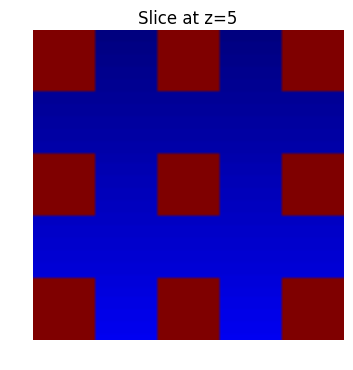

In [6]:
simEasyGrid = np.zeros((100, 100, 100))

for i in range(100):
    for j in range(100):
        for k in range(100):
            simEasyGrid[i][j][k] = j
            
for i in range(4):
    for j in range(4):
        for k in range(4):
            simEasyGrid[20*(2*j): 20*(2*j + 1), 20*(2*i): 20*(2*i + 1), 20*(2*k): 20*(2*k + 1)] = 1000
            
plt.imshow(simEasyGrid[5])
plt.axis('off')
plt.title('Slice at z=5')
plt.show()

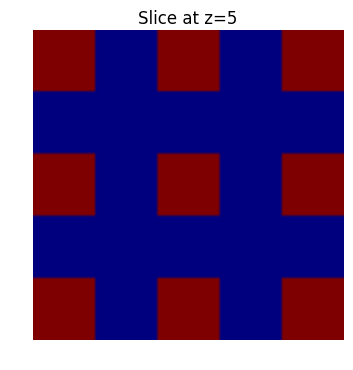

In [7]:
afterThresh = adaptiveThreshold(simEasyGrid, 1, 20, 1, 50)
plt.imshow(afterThresh[5])
plt.axis('off')
plt.title('Slice at z=5')
plt.show()

## Easy Sim Analysis 
As you can see above, Adaptive Thresholding clearly identifies foreground from varying background effectively. 

## Realistic Sim 
The realistic simulation will be run on data that models the distribution of synapses and noise in our true data.

In [8]:
def generatePointSet():
    center = (rand(0, 9), rand(0, 999), rand(0, 999))
    toPopulate = []
    for z in range(-3, 2):
        for y in range(-3, 2):
            for x in range(-3, 2):
                curPoint = (center[0]+z, center[1]+y, center[2]+x)
                #only populate valid points
                valid = True
                for dim in range(3):
                    if curPoint[dim] < 0 or curPoint[dim] >= 1000:
                        valid = False
                if valid:
                    toPopulate.append(curPoint)
    return set(toPopulate)
    
def generateTestVolume():
    #create a test volume
    volume = np.zeros((10, 1000, 1000))
    myPointSet = set()
    for _ in range(rand(1000, 2000)):
        potentialPointSet = generatePointSet()
        #be sure there is no overlap
        while len(myPointSet.intersection(potentialPointSet)) > 0:
                potentialPointSet = generatePointSet()
        for elem in potentialPointSet:
            myPointSet.add(elem)
    #populate the true volume
    for elem in myPointSet:
        volume[elem[0], elem[1], elem[2]] = rand(40000, 60000)
    #introduce noise
    noiseVolume = np.copy(volume)
    for z in range(noiseVolume.shape[0]):
        for y in range(noiseVolume.shape[1]):
            for x in range(noiseVolume.shape[2]):
                if not (z, y, x) in myPointSet:
                    toPop = rand(0, 10)
                    if toPop == 5:
                        noiseVolume[z][y][x] = rand(0, 60000)
    return volume, noiseVolume

## Scoring Code
The following code was lifted from the precisionrecall notebook and calculates f1 score, among other stats

In [9]:
def f1score(trueClusterList, testClusterList):
    
    tp = 0
    fp = 0
    fn = 0
    
    testClusterTuples = []
    for elem in testClusterList:
        myTupleList = []
        members = elem.members
        for member in members:
            myTupleList.append(tuple(member))
        testClusterTuples.append(myTupleList)

    trueClusterTuples = []
    for elem in trueClusterList:
        myTupleList = []
        members = elem.members
        for member in members:
            myTupleList.append(tuple(member))
        trueClusterTuples.append(myTupleList)
    
    truePositives = []
    for testList in testClusterTuples:
        found = False
        for trueList in trueClusterTuples:
            if len(set(testList).intersection(set(trueList))) > 0:
                found = True
        if found:
            truePositives.append(testList)
            tp+=1
    
    fp = len(testClusterList) - tp
    fn = len(trueClusterList) - tp
    precision = float(tp)/float(fp+tp)
    recall = float(tp)/float(tp+fn)
    f1 = (2*precision*recall)/(precision+recall)
    
    return precision, recall, f1, truePositives, trueClusterTuples, testClusterTuples

In [20]:
testVol, noiseVol = generateTestVolume()

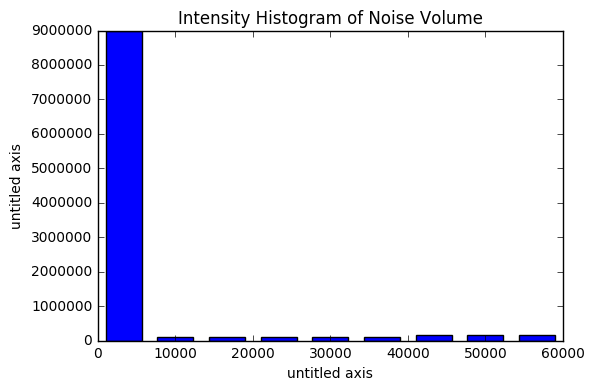

In [12]:
mv.generateVoxHist(noiseVol, figName="Intensity Histogram of Noise Volume", bins=9) 

In [21]:
adaptiveThresh = adaptiveThreshold(noiseVol, 9, 9, 9, 93)
clusterList = cLib.clusterThresh(adaptiveThresh, lowerFence=35, upperFence=65)
displayIm = np.zeros_like(adaptiveThresh)
for cluster in range(len(clusterList)):
    for member in range(len(clusterList[cluster].members)):
        z, y, x = clusterList[cluster].members[member]
        displayIm[z][y][x] = 1

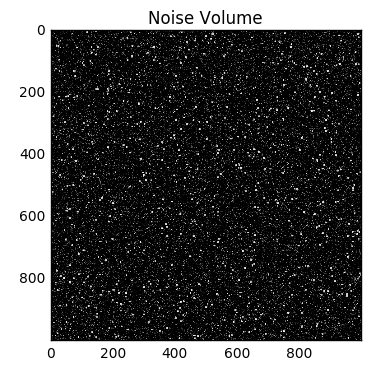

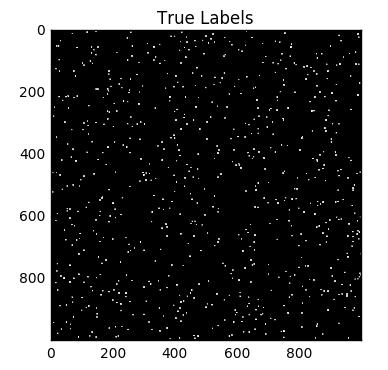

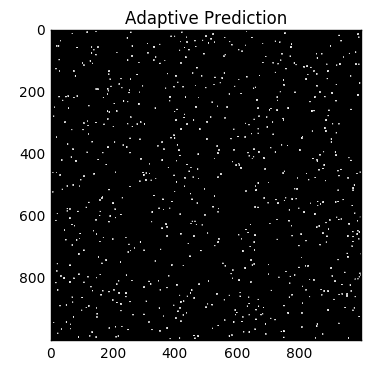

In [15]:
plt.figure()
plt.title('Noise Volume')
plt.imshow(noiseVol[5], cmap='gray')
plt.show()

plt.figure()
plt.imshow(testVol[5], cmap='gray')
plt.title('True Labels')
plt.show()

plt.figure()
plt.imshow(displayIm[5], cmap='gray')
plt.title('Adaptive Prediction')
plt.show()

In [22]:
clustersA = cLib.clusterThresh(adaptiveThresh[4:6], lowerFence=40, upperFence=60)
clustersT = cLib.clusterThresh(testVol[4:6], lowerFence=40, upperFence=60)

In [23]:
precisionA, recallA, f1A, _, _, _ = f1score(clustersT, clustersA)

In [24]:
print 'Adaptive:'
print '\tPrecision: ', precisionA
print '\tRecall: ', recallA
print '\tf1: ', f1A

Adaptive:
	Precision:  0.993039443155
	Recall:  0.918454935622
	f1:  0.954292084727


In [102]:
def executeRealisticSim(i):
    
    realSimA = adaptiveThreshold(noiseVol, 2*i + 1, 2*i + 1, 2*i + 1, 92)
    
    clustersA = cLib.clusterThresh(realSimA[4:6], lowerFence=40, upperFence=60)
    
    precisionA, recallA, f1A, _, _, _ = f1score(clustersT, clustersA)
    
    print 'Adaptive:'
    print '\tPrecision: ', precisionA
    print '\tRecall: ', recallA
    print '\tf1: ', f1A

In [104]:
for i in range(5):
    executeRealisticSim(i)

Adaptive:
	Precision:  0.988587731812
	Recall:  0.871698113208
	f1:  0.926470588235
Adaptive:
	Precision:  0.98891966759
	Recall:  0.898113207547
	f1:  0.941331575478
Adaptive:
	Precision:  0.991655076495
	Recall:  0.896855345912
	f1:  0.941875825627
Adaptive:
	Precision:  0.991655076495
	Recall:  0.896855345912
	f1:  0.941875825627
Adaptive:
	Precision:  0.990450204638
	Recall:  0.91320754717
	f1:  0.950261780105


In [105]:
def executeRealisticSimNarrow(i):
    
    realSimA = adaptiveThreshold(noiseVol, 9, 9, 9, 90 + i)
    
    clustersA = cLib.clusterThresh(realSimA[4:6], lowerFence=40, upperFence=60)
    
    precisionA, recallA, f1A, _, _, _ = f1score(clustersT, clustersA)
    
    print 'Adaptive:'
    print '\tPrecision: ', precisionA
    print '\tRecall: ', recallA
    print '\tf1: ', f1A

In [107]:
for i in range(8):
    executeRealisticSimNarrow(i)

Adaptive:
	Precision:  0.9568
	Recall:  0.752201257862
	f1:  0.842253521127
Adaptive:
	Precision:  0.974963181149
	Recall:  0.832704402516
	f1:  0.898236092266
Adaptive:
	Precision:  0.990450204638
	Recall:  0.91320754717
	f1:  0.950261780105
Adaptive:
	Precision:  0.997322623829
	Recall:  0.937106918239
	f1:  0.966277561608
Adaptive:
	Precision:  1.0
	Recall:  0.933333333333
	f1:  0.965517241379
Adaptive:
	Precision:  0.993288590604
	Recall:  0.74465408805
	f1:  0.851186196981
Adaptive:
	Precision:  0.847328244275
	Recall:  0.139622641509
	f1:  0.239740820734
Adaptive:
	Precision:  0.15
	Recall:  0.00377358490566
	f1:  0.00736196319018


In [119]:
statListA = []

def executeRealisticSimFresh():
    testVol, noiseVol = generateTestVolume()
    
    realSimA = adaptiveThreshold(noiseVol, 9, 9, 9, 93)
    
    clustersA = cLib.clusterThresh(realSimA[4:6], lowerFence=40, upperFence=60)
    clustersT = cLib.clusterThresh(testVol[4:6], lowerFence=40, upperFence=60)
    
    precisionA, recallA, f1A, _, _, _ = f1score(clustersT, clustersA)
    
    print 'Adaptive:'
    print '\tPrecision: ', precisionA
    print '\tRecall: ', recallA
    print '\tf1: ', f1A
    
    statListA.append([precisionA, recallA, f1A])

In [120]:
for _ in range(10):
    executeRealisticSimFresh()

Adaptive:
	Precision:  0.992467043315
	Recall:  0.921328671329
	f1:  0.955575702629
Adaptive:
	Precision:  0.991701244813
	Recall:  0.92277992278
	f1:  0.956
Adaptive:
	Precision:  0.993231810491
	Recall:  0.933227344992
	f1:  0.962295081967
Adaptive:
	Precision:  0.994174757282
	Recall:  0.90780141844
	f1:  0.949026876738
Adaptive:
	Precision:  1.0
	Recall:  0.929192546584
	f1:  0.963296844816
Adaptive:
	Precision:  0.994397759104
	Recall:  0.913770913771
	f1:  0.952380952381
Adaptive:
	Precision:  0.993865030675
	Recall:  0.910112359551
	f1:  0.950146627566
Adaptive:
	Precision:  0.993071593533
	Recall:  0.918803418803
	f1:  0.954495005549
Adaptive:
	Precision:  0.997942386831
	Recall:  0.927342256214
	f1:  0.961347869177
Adaptive:
	Precision:  0.998487140696
	Recall:  0.921787709497
	f1:  0.958605664488


In [121]:
precListA = [elem[0] for elem in statListA]

recListA = [elem[1] for elem in statListA]

fListA = [elem[2] for elem in statListA]

In [122]:
print 'Adaptive Filer:'
print '\tPrecision: ', np.average(precListA), '\t Variance', np.var(precListA)
print '\tRecall: ', np.average(recListA), '\t Variance ', np.var(recListA)
print '\tF1: ', np.average(fListA), '\t Variance ', np.var(fListA)

Adaptive Filer:
	Precision:  0.994933876674 	 Variance 7.22488435595e-06
	Recall:  0.920614656196 	 Variance  6.09089663114e-05
	F1:  0.956317062531 	 Variance  2.25684866032e-05


# Conclusion From Simulations
The results from Adaptive Threshold were surprisingly good. The F1 score had an average of 90 with a variance of .00013. However, this method is highly dependent on parameters and thus, I am not confident it will be effective on all data sets.

In [50]:
data0 = tIO.unzipChannels(tIO.loadTiff('../data/SEP-GluA1-KI_tp1.tif'))[0][5:10]

In [79]:
realAdaptive = adaptiveThreshold(data0, 5, 5, 8, 93)

Number of clusters: 75058
Average Volume: 3.64956433691
Cluster Density: 0.0522478103638


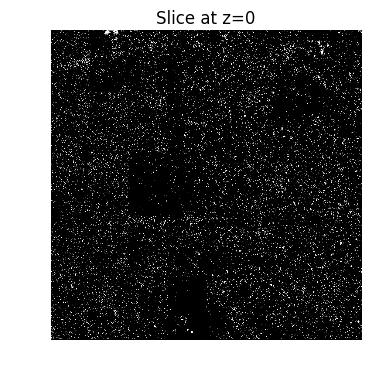

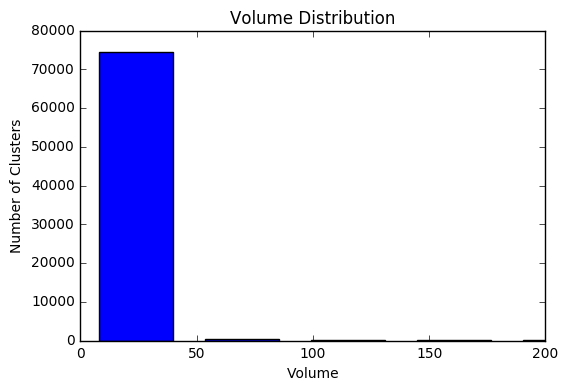

In [80]:
cLib.clusterAnalysis(realAdaptive, lowerFence=0, upperFence=200, sliceVis=0, bins=50)

# Final Conslusion 
Adaptive Thresholding works extremely well. It gives us all of the statistics we like. I am happy :)